# VAE-GAN for X-ray image generation

The aim of this project is to implement and validate a VAE-GAN as per the original paper by ABL Larsen et al.
https://arxiv.org/abs/1512.09300

<img src="https://miro.medium.com/max/2992/0*KEmfTtghsCDu6UTb.png" width="400">


In [123]:
import os
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import shutil

from glob import glob
from os.path import join
from os import listdir
from pathlib import Path


from torch import optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.nn.modules.loss import L1Loss
from torch.nn.modules.loss import MSELoss


def numpy_from_tensor(x):
  return x.detach().cpu().numpy()

In [124]:
file_download_link = "https://docs.google.com/uc?export=download&id=1lsCyvsaZ2GMxkY5QL5HFz-I40ihmtE1K"
# !wget -O ImagesHands.zip --no-check-certificate "$file_download_link"
# !unzip -o ImagesHands.zip

In [125]:
def delete_all_files(folder_path):
    # Loop through all files in the specified directory
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)  # Create full file path
            if os.path.isfile(file_path):  # Check if it is a file
                os.remove(file_path)  # Delete the file
os.makedirs("C:/Users/allan/Downloads/VAE-GAN/edited_nii", exist_ok=True)
delete_all_files("C:/Users/allan/Downloads/VAE-GAN/edited_nii")
#shutil.copy(".gitignore", "edited_nii/")

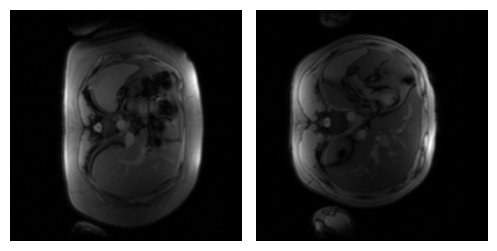

Batch shape: torch.Size([2, 1, 224, 224])


In [ ]:
class NiftyDataset(Dataset):
    """
    Class that loads nii files, extracts 2D slices and normalizes them between 0 and 1
    """

    def __init__(self, root_dir, slice_selection='middle'):
        """
        Parameters:
        root_dir - string - path towards the folder containing the data
        slice_selection - string - 'middle' for middle slice, 'all' for all slices
        """
        self.root_dir = root_dir
        self.filenames = listdir(self.root_dir)
        self.slice_selection = slice_selection
        
        # If using all slices, we need to account for total number of slices
        if self.slice_selection == 'all':
            self.slices_info = []
            for filename in self.filenames:
                img = nib.load(os.path.join(self.root_dir, filename))
                n_slices = img.shape[2]
                self.slices_info.extend([(filename, i) for i in range(n_slices)])

    def __len__(self):
        if self.slice_selection == 'all':
            return len(self.slices_info)
        return len(self.filenames)

    def __getitem__(self, idx):
        if self.slice_selection == 'all':
            # Get filename and slice index for this idx
            filename, slice_idx = self.slices_info[idx]
        else:
            # Just get the filename, we'll use middle slice
            filename = self.filenames[idx]
            
        # Load the nifty image
        img = nib.load(os.path.join(self.root_dir, filename))
        img = np.array(img.get_fdata())
        
        # Normalize the image to the range [0, 1]
        img = (img - img.min()) / (img.max() - img.min())
        
        if self.slice_selection == 'all':
            # Get the specified slice
            img_slice = img[:, :, slice_idx]
        else:
            # Get middle slice
            middle_slice = img.shape[2] // 2
            img_slice = img[:, :, middle_slice]
        
        # Add channel dimension [1, height, width]
        img_slice = np.expand_dims(img_slice, 0)
        
        # Convert to float32 for better compatibility with PyTorch
        return img_slice.astype(np.float32)

# Usage example:
path = "C:/Users/allan/Downloads/VAE-GAN/edited_nii"

# Create dataset (using middle slice by default)
dataset = NiftyDataset(root_dir=Path(path))

# Create DataLoader
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=2, drop_last=False)

# Visualization example
def show_batch(dataloader):
    batch = next(iter(dataloader))
    plt.figure(figsize=(10, 5))
    for i in range(min(batch.shape[0], 4)):  # Show up to 4 images
        plt.subplot(1, 4, i + 1)
        plt.imshow(batch[i, 0].numpy(), cmap='gray')  # Remove channel dimension for plotting
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show a batch of images
show_batch(dataset_loader)

# Print shape information for verification
sample_batch = next(iter(dataset_loader))
print(f"Batch shape: {sample_batch.shape}")  # Should be [batch_size, 1, height, width]

# Part 1 - Encoder & Decoder


In [188]:
# YOUR CODE HERE

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils


class ResBlockVAE(nn.Module):
    """
    Implements a pre-activation residual block with mode "level", "upsample", or "downsample".

    Args:
        in_channels (int):
            Number of channels in the input tensor.
        out_channels (int):
            Number of output channels in the block.
        mode (str):
            Residual block mode, can be "level", "upsample", or "downsample".
    """

    def __init__(self, in_channels, out_channels, mode="level", res_mode="pre-activation", dropout_prob=0.5):
        super().__init__()
        self.res_mode = res_mode

        self.bn1 = nn.BatchNorm2d(in_channels) if res_mode == "pre-activation" else nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(p=dropout_prob)  # add dropout layer

        # only conv1 and shortcut are different for different modes
        if mode == "level":
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            # self.shortcut = nn.Sequential()  # identity mapping
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        elif mode == "upsample":
            self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
            self.shortcut = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        elif mode == "downsample":
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.activation_fun = nn.LeakyReLU(inplace=False)

    def forward(self, x):
        # original forward pass: Conv2d > BatchNorm2d > ReLU > Conv2D >  BatchNorm2d > ADD > ReLU
        if self.res_mode == "standard":
            out = self.conv1(x)
            out = self.bn1(out)
            out = self.activation_fun(out)
            out = self.dropout(out)  # add dropout layer
            out = self.conv2(out)
            out = self.bn2(out)
            out += self.shortcut(x)
            out = self.activation_fun(out)

        # pre-activation forward pass: BatchNorm2d > ReLU > Conv2d > BatchNorm2d > ReLU > Conv2d > ADD
        elif self.res_mode == "pre-activation":
            out = self.bn1(x)
            out = self.activation_fun(out)
            out = self.dropout(out)  # add dropout layer
            out = self.conv1(out)
            out = self.bn2(out)
            out = self.activation_fun(out)
            out = self.conv2(out)
            out += self.shortcut(x)

        return out


from collections import OrderedDict
import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, in_channels, depth, length, feature_size, block=ResBlockVAE):
        super(Encoder, self).__init__()

        """
        This module is responsible for encoding the input data by applying a series of ResBlocks, which consist of convolutional layers and skip connections.

        Args:

            in_channels (int):
                the number of channels in the input data.
            depth (int):
                the depth of the network, i.e., the number of downsample operations to perform.
            length (int):
                the number of ResBlocks to apply at each resolution level.
            feature_size (int):
                the number of output channels in the first ResBlock, which will be doubled after each downsample operation.
            block (nn.Module):
                the type of ResBlock to use (default: ResBlock).

        """
        encoder = OrderedDict()

        # Create the first ResBlock to process the input data
        for i in range(length):
            # Create a ResBlock to have the desired initial feature size
            encoder["encoder-depth_0-level_" + str(i)] = block(in_channels, feature_size, mode="level")
            in_channels = feature_size

        for d in range(1, depth + 1):
            # Modify the in_channels and feature_size accordingly
            in_channels = feature_size
            feature_size *= 2

            # Create a ResBlock to downsample to the desired feature size
            encoder["encoder-depth_" + str(d) + "-downsample"] = block(in_channels, feature_size, mode="downsample")

            for item in range(0, length - 1):
                # Create a ResBlock to further process the data
                # keep it at the same feature depth and resolution
                encoder["encoder-depth_" + str(d) + "-level_" + str(item)] = block(feature_size, feature_size, mode="level")

        self.encoder = nn.Sequential(encoder)

    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, depth, length, reconstruction_channels, block=ResBlockVAE):
        """
        The Decoder takes the following parameters:

            in_channels (int):
                the number of channels in the input encoded data.
            depth (int):
                the depth of the network, i.e., the number of upsample operations to perform.
            length (int):
                the number of ResBlocks to apply at each resolution level.
            reconstruction_channels (int):
                the number of output channels in the final ResBlock, which should be the same as the number of channels in the original input data.
            block (nn.Module):
                the type of ResBlock to use (default: ResBlock).

        """
        super().__init__()

        decoder = OrderedDict()

        # Calculate the initial feature_size
        feature_size = in_channels // 2

        for d in range(depth, 0, -1):
            # Create a ResBlock to upsample to the desired feature size
            decoder["decoder-depth_" + str(d) + "-upsample"] = block(in_channels, feature_size, mode="upsample")

            for item in range(0, length - 1):
                # Create a ResBlock to further process the data keep it at the same feature depth and resolution
                decoder["decoder-depth_" + str(d) + "-level_" + str(item)] = block(feature_size, feature_size, mode="level")

            # Modify the in_channels and feature_size accordingly
            in_channels = feature_size
            feature_size = in_channels // 2

        # Create the a ResBlock that outputs the required number of channels for the output
        decoder["decoder-depth_0-reconstruction"] = block(in_channels, reconstruction_channels, mode="level")

        self.decoder = nn.Sequential(decoder)

    def forward(self, x):
        return self.decoder(x)

### REPORT

The architecture choices for the VAE-GAN made above are based on a variety of factors that aim to improve training efficiency and performance. One critical choice is to use residual blocks and convolutional layers for image data instead of fully connected layers. This enables the model to learn spatial hierarchies and preserve spatial information more effectively while decreasing the number of trainable parameters, lowering overfitting and computational cost.

The use of pre-activation residual blocks provides an alternative mode for hyperparameter tuning, which may improve model convergence. To stabilise training and prevent mode collapse, spectral normalisation is applied to the discriminator's convolutional layers in each residual block. The activation function LeakyReLU is used to alleviate the vanishing gradient problem by allowing small negative values to pass through.

By reducing the model's reliance on specific features during training, dropout layers in the architecture help to introduce some degree of regularisation, which can prevent overfitting. Batch normalisation is used to address the internal covariate shift issue, resulting in faster training and simpler weight initialization. It also allows the model to employ faster learning rates and a broader range of activation functions.

Alternative decisions could have included using different types of residual blocks, activation functions, or normalization techniques. More specifically:

### Different Residual Block
Another decision that could have been made is to use a different type of residual block, such as a bottleneck residual block or a dilated residual block. Bottleneck residual blocks can help to reduce the number of parameters in the model, while dilated residual blocks can help to increase the receptive field of the model.

Advantages:
- Can help to reduce the number of parameters in the model
- Can help to increase the receptive field of the model

Disadvantages:
- Bottleneck residual blocks can be computationally complex, which can reduce scalability to large datasets 
- Dilated residual blocks can lead to increased memory usage

### Different Activation Function
Instead of using LeakyReLU, a different activation function could have been used, such as ELU or SELU. ELU is similar to ReLU but allows for negative values to pass through, while SELU is a self-normalizing activation function that can help to improve the performance.

Advantages:
- ELU and SELU can help to reduce the vanishing gradient problem
- SELU can help to improve the performance of the model

Disadvantages:
- ELU and SELU can be both computationally expensive

### Different Normalization
Instead of using batch normalization, a different type of normalization could have been used, such as layer normalization or instance normalization. Layer normalization normalizes the inputs of each layer, while instance normalization normalizes the inputs of each instance. Or no normalization could have been used, which would have allowed for faster training but could have led to overfitting.

Advantages:
- layer normalization normalizes each input in the batch independently across all features, making it independent of batch size and effective for smaller batches
- instance normalization can be used to normalize feature maps of arbitrary sizes, unlike batch normalization which requires fixed batch sizes.
- no normalization would have allowed for faster training

Disadvantages:
- layer normalization may not be as effective at improving the training time and accuracy of a neural network compared to batch normalization
- instance normalization can lead to over-fitting because it normalizes each instance independently of the others
- no normalization could have led to overfitting

_______________________________


# Part 2 - Adversarial Learning (discriminator) 

Now, the adversarial learning loss, as per the paper from Larsen et al.

In [189]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class ResBlockDiscriminator(nn.Module):
    """
    Module to implement a residual block for a discriminator in a GAN network.

        Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        res_stride (int, optional): Stride for convolutional layers in the residual block. Defaults to 1.
        res_mode (str, optional): Type of residual block to use. Can be "pre-activation" or "standard". Defaults to "pre-activation".
        dropout_prob (float, optional): Dropout probability for the dropout layer. Defaults to 0.5.

        Returns:
        out (tensor): Output tensor from the residual block.

    """

    def __init__(self, in_channels, out_channels, res_stride=1, res_mode="pre-activation", dropout_prob=0.5):
        super().__init__()
        self.res_mode = res_mode

        self.bn1 = nn.BatchNorm2d(in_channels) if res_mode == "pre-activation" else nn.BatchNorm2d(out_channels)

        self.conv1 = utils.spectral_norm(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=res_stride, padding=1, bias=False)
        )
        self.dropout = nn.Dropout2d(p=dropout_prob)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = utils.spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))

        if res_stride != 1 or out_channels != in_channels:  # if the image size changes or the number of channels changes
            self.shortcut = nn.Sequential(
                utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=res_stride, bias=False)),
                nn.BatchNorm2d(out_channels),
            )

        else:
            self.shortcut = nn.Sequential()

        self.activation_fun = nn.LeakyReLU(0.2, inplace=False)

    def forward(self, x):
        # original forward pass: Conv2d > BatchNorm2d > ReLU > Conv2D >  BatchNorm2d > ADD > ReLU
        if self.res_mode == "standard":
            out = self.conv1(x)
            out = self.dropout(out)
            out = self.bn1(out)
            out = self.activation_fun(out)
            out = self.conv2(out)
            out = self.bn2(out)
            out += self.shortcut(x)
            out = self.activation_fun(out)

        # pre-activation forward pass: BatchNorm2d > ReLU > Conv2d > BatchNorm2d > ReLU > Conv2d > ADD
        elif self.res_mode == "pre-activation":
            out = self.bn1(x)
            out = self.activation_fun(out)
            out = self.conv1(out)
            out = self.dropout(out)
            out = self.bn2(out)
            out = self.activation_fun(out)
            out = self.conv2(out)
            out += self.shortcut(x)

        return out


class Discriminator(nn.Module):
    def __init__(
        self,
        block,
        num_stride_conv1: int,
        num_features_conv1: int,
        num_blocks: list[int],
        num_strides_res: list[int],
        num_features_res: list[int],
    ):
        super().__init__()

        assert len(num_blocks) == len(num_strides_res) == len(num_features_res), "length of lists must be equal"
        input_size = np.array([1, 256, 256])  # (channels, height, width)
        self.block = block
        self.activation_fun = nn.LeakyReLU(0.2, inplace=False)

        # first conv layer and batch norm
        self.in_planes = num_features_conv1
        self.conv1 = nn.Conv2d(input_size[0], num_features_conv1, kernel_size=3, stride=num_stride_conv1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features_conv1)

        # add res layers iteratively for easier modification
        res_layers = []
        for i in range(len(num_blocks)):
            res_layers.append(self._make_layer(planes=num_features_res[i], num_blocks=num_blocks[i], stride=num_strides_res[i]))
        self.res_layers = nn.Sequential(*res_layers)

        # calculate the length of the linear layer with the given input size
        linear_len = input_size // num_stride_conv1 // 4  # 4 is the pooling factor
        linear_len = np.floor_divide(linear_len, np.prod(num_strides_res))
        linear_len[0] = 1
        self.linear_len = np.prod(linear_len) * num_features_res[-1]

        # assert self.linear_len > 1024, f"linear_len, currently {self.linear_len} must be greater than 1024"

        self.linear_1 = nn.Linear(self.linear_len, 1024)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 256)
        self.linear_4 = nn.Linear(256, 1)

        # self.classifier = nn.Sigmoid()

    def forward(self, img):
        out = self.conv1(img)
        out = self.bn1(out)
        out = self.activation_fun(out)

        out = self.res_layers(out)
        out = F.avg_pool2d(out, 4)  # size of the pooling window

        out = out.view(out.size(0), -1)
        out = self.linear_1(out)
        out = self.activation_fun(out)

        out = self.linear_2(out)
        out = self.activation_fun(out)

        out = self.linear_3(out)
        out = self.activation_fun(out)

        out = self.linear_4(out)
        # validity = self.classifier(out) # for wasserstein loss

        return out

    def _make_layer(self, planes, num_blocks, stride):
        layers = []

        layers.append(self.block(in_channels=self.in_planes, out_channels=planes, res_stride=stride))

        for _ in np.arange(num_blocks - 1):
            layers.append(self.block(in_channels=planes, out_channels=planes))

        self.in_planes = planes

        return nn.Sequential(*layers)


### REPORT
_______________________________



The discriminator architecture described above is intended to be flexible and scalable. A customizable set of residual layers, a series of linear layers, and an activation function are the main components of this architecture.

The discriminator accepts a set of input parameters that allow the architecture to be easily modified and scaled. These parameters include the number of stride values for the first convolutional layer (num stride conv1), the number of output features for the first convolutional layer (num features conv1), and lists with the number of residual blocks (num blocks), residual stride values (num strides res), and residual output features (num features res).

The design process for this architecture was to make it adaptable to different tasks and input sizes. The network can capture more complex and hierarchical features in the input data by using a scalable and customizable set of residual layers. This is accomplished by iteratively adding residual layers based on the parameter lists provided. This adaptability makes it easier to adapt the architecture to new tasks or input sizes.

_______________________________


# Part 3 - Code Processor and Network 

In order to obtain a VAE-GAN, we need to implement a the VAE code processor using either a Dense AutoEncoder or a spatial Code Processor. Implement the code processor of your choice as per the Unsupervised Learning lecture, and glue the encoder, decoder decriminator and code processor into a single network. Write your code below and report on your decisions in the cell after your code. 

In [190]:
class SpatialVAECodeProcessor(nn.Module):

    """
    SpatialVAECodeProcessor module for Variational Autoencoder.

    The module contains methods for encoding and decoding inputs,
    along with a re-parametrization trick to sample from the
    latent representation during training.

    Attributes:
        log_vars_upper_bound (int): Upper bound for the logarithmic variance.
        log_vars_lower_bound (float): Lower bound for the logarithmic variance.
        is_training (bool): Indicates if the module is in training mode.
        log_var (nn.Conv2d): 2D convolutional layer for the logarithmic variance.
        mu (nn.Conv2d): 2D convolutional layer for the mean.

    Methods:
        forward(x): Processes input x through the module and returns the encoded value,
        along with the mean and logarithmic variance.
        encode(x): Encodes input x using the mean layer only.
        decode(x): Decodes input x without any processing.
        set_is_training(is_training): Sets the training mode of the module.

    """

    def __init__(self, feature_depth, is_training):
        super().__init__()
        self.log_vars_upper_bound = 50
        self.log_vars_lower_bound = -self.log_vars_upper_bound
        self.is_training = is_training

        # feature_depth = feature_size * np.power(2, depth)

        # create 2D convolutional layers for the log_var and mean
        self.log_var = nn.Conv2d(
            in_channels=feature_depth,
            out_channels=feature_depth,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        # output is the same size as input
        self.mu = nn.Conv2d(
            in_channels=feature_depth,
            out_channels=feature_depth,
            kernel_size=3,
            stride=1,
            padding=1,
        )

    def forward(self, x):
        # code the re-parametrization trick you will need
        log_var = torch.clamp(self.log_var(x), self.log_vars_lower_bound, self.log_vars_upper_bound)

        mu = self.mu(x)

        if self.is_training:
            std = log_var.mul(0.5).exp_()
            esp = torch.randn_like(mu)
            x = mu + std * esp
        else:
            x = mu

        return x, mu, log_var

    def encode(self, x):
        # code the necessary processing of the latent representation
        x = self.mu(x)
        return x

    def decode(self, x):
        return x

    def set_is_training(self, is_training):
        self.is_training = is_training


class UnsupervisedGeneratorNetwork(nn.Module):

    """
    Methods:
        __init__(self, encoder, code_processor, decoder, is_vae):
            initializes the UnsupervisedNetwork class
        forward(self, x):
            performs forward pass through the network and returns the output
        encode(self, x):
            encodes the input data x into a latent code
        decode(self, x):
            decodes the latent code x into the output data
        set_is_training(self, is_training):
            sets the network training status to is_training

    Attributes:

        is_vae:
            a boolean indicating whether the network architecture includes a Variational Autoencoder (VAE) code processor
        is_training:
            a boolean indicating whether the network is currently in training mode or not
        encoder:
            the encoder network module of the UnsupervisedNetwork
        code_processor:
            the code processing network module of the UnsupervisedNetwork
        decoder:
            the decoder network module of the UnsupervisedNetwork
    """

    def __init__(self, encoder, code_processor, decoder, is_vae):
        super().__init__()
        # Class attributes
        self.is_vae = is_vae
        self.is_training = True

        # Network architecture
        self.encoder = encoder
        self.code_processor = code_processor
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)

        if self.is_vae:
            x, mu, log_var = self.code_processor(x)
        else:
            x = self.code_processor(x)

        x = self.decoder(x)

        if self.is_vae:
            return x, mu, log_var
        else:
            return x

    def encode(self, x):
        x = self.encoder(x)
        x = self.code_processor.encode(x)

        return x

    def decode(self, x):
        x = self.code_processor.decode(x)
        x = self.decoder(x)
        return x

    def set_is_training(self, is_training):
        self.code_processor.set_is_training(is_training)


### REPORT

The code processor chosen for this network is a Spatial Variational Autoencoder (VAE) code processor. The main reason for this selection is that Spatial VAEs are especially well-suited for handling high-resolution images while still capturing complex spatial dependencies in the data. Convolutional layers in the latent space are used by the Spatial VAE code processor to help retain spatial information and better model local features within the image. This is especially useful for tasks involving images with intricate details and patterns.

The network is made up of an encoder, a code processor, and a decoder. The encoder is in charge of reducing the size of the input image to a lower-dimensional latent representation. In this case, a Spatial VAE is used to process the latent representation while imposing a probabilistic structure on the latent space. The image is then reconstructed by the decoder using the processed latent representation. When the network is set up as a VAE, the code processor uses the re-parametrization trick during training to ensure that the network learns a continuous and smooth latent space.

The inclusion of separate convolutional layers for the mean (mu) and logarithmic variance (log var) is a notable feature of the Spatial VAE code processor. This enables the network to learn distinct parameters for these two important components of the latent space probability distribution. To prevent extreme values and ensure numerical stability during training, the logarithmic variance is clamped within an upper and lower bound.

The network's loss function varies depending on whether it is configured as a VAE or a standard autoencoder. In the case of a VAE, the loss function consists of two components: the reconstruction loss, which measures the difference between the input and the reconstructed image, and the Kullback-Leibler (KL) divergence, which enforces a smooth and continuous latent space by encouraging the learned probability distribution to be close to a standard normal distribution. The reconstruction loss is typically the only loss function for a standard autoencoder.

_______________________________


# Part 4 - Training Loop

Now, define the training loop for the VAE-GAN and train the network itself.

In [191]:
import json
from torchvision.utils import save_image
import shutil

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torch import nn
import torch.nn.functional as F


def init_weights(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight)
        if module.bias is not None:
            module.bias.data.zero_()
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.fill_(1)
        module.bias.data.zero_()


import torch
import numpy as np
from torch import autograd

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor


def compute_gradient_penalty(D, real_samples, fake_samples):
    # calculate interpolated samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)

    d_interpolates = D(interpolates)
    fake = Tensor(real_samples.shape[0], 1).fill_(1.0)

    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)

    # Calculate the gradient penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty


def train_network_wgan(
    n_epochs,
    dataloader,
    vae_generator,
    discriminator,
    optimizer_G,
    optimizer_D,
    reconstruction_loss_funs,
    Tensor,
    sample_interval,
    gan_inference_folder,
    # weights
    adversarial_loss_weight,
    reconstruction_loss_weight,
    kl_weight,
    # kl_annealing_factor=0.99,
    # weight for discriminator
    clip_value=0.01,
    # logger
    use_neptune=False,
    n_critics=5,
    lambda_gp=10,
):
    shutil.rmtree(gan_inference_folder, ignore_errors=True)
    os.makedirs(gan_inference_folder, exist_ok=True)

    #if use_neptune:
     #   import neptune
#
    #    with open(Path("private") / "neptune.json", "r") as f:
   #         neptune_api_token = json.load(f)
   #         run = neptune.init_run(**neptune_api_token)  # your credentials

    for epoch in range(n_epochs):
        for i, imgs in enumerate(dataloader):
            # kl_weight = kl_weight * (kl_annealing_factor**epoch)

            imgs.to(device)

            # |------------------------|
            # | Discriminator training |
            # |------------------------|

            real_imgs = imgs.type(Tensor)

            optimizer_D.zero_grad()

            gen_imgs, code_mu, code_log_var = vae_generator(real_imgs)

            # Calculate the losses for the discriminator
            real_loss = -torch.mean(discriminator(real_imgs))
            fake_loss = torch.mean(discriminator(gen_imgs.detach()))

            # Compute the gradient penalty
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, gen_imgs.data)

            d_loss = real_loss + fake_loss + (lambda_gp * gradient_penalty)
            # d_loss = d_loss**2

            d_loss.backward()
            optimizer_D.step()

            # clamp discriminator's weights
            for p in discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)

            # |------------------------|
            # |   Generator training   |
            # |------------------------|

            if i % n_critics == 0:
                optimizer_G.zero_grad()

                # Calculate the loss for the generator
                adversarial_loss = -torch.mean(discriminator(gen_imgs))

                recon_losses = [recon_loss(gen_imgs, real_imgs) for recon_loss in reconstruction_loss_funs]
                recon_loss = sum(recon_losses)

                # Add the VAE kl_divergence
                code_log_var = torch.flatten(code_log_var, start_dim=1)
                code_mu = torch.flatten(code_mu, start_dim=1)
                kl_divergence = -0.5 * torch.sum(1 + code_log_var - code_mu.pow(2) - code_log_var.exp())
                kl_divergence = kl_divergence.mean()

                g_loss = (
                    (adversarial_loss_weight * adversarial_loss)
                    + (reconstruction_loss_weight * recon_loss)
                    + (kl_weight * kl_divergence)
                )

                g_loss.backward()
                optimizer_G.step()

                # print real and fake loss
            print(
                f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item().__round__(3)}] [G loss: {g_loss.item().__round__(3)}] [Recon loss: {recon_loss.item().__round__(3)}] [KL: {kl_divergence.item().__round__(3)}], [Real loss: {real_loss.item().__round__(3)}], [Fake loss: {fake_loss.item().__round__(3)}] [adversarial loss: {adversarial_loss.item().__round__(3)}]]"
            )

            # run["train/loss"].append(0.9**epoch)
            if use_neptune:
                run["D loss"].append(d_loss.item())
                run["G loss"].append(g_loss.item())
                run["Recon loss"].append(recon_loss.item())
                run["KL"].append(kl_divergence.item())
                run["D Real loss"].append(real_loss.item())
                run["D Fake loss"].append(fake_loss.item())
                run["adversarial loss"].append(adversarial_loss.item())

            batches_done = epoch * len(dataloader) + i

            if batches_done % sample_interval == 0:
                save_image(gen_imgs.data[:25], gan_inference_folder / f"{batches_done}.png", nrow=5, normalize=True)

    if use_neptune:
        run.stop()


def experiment(
    code_processor_parameters,
    network_depth,
    network_length,
    feature_size,
    # discriminator
    discriminator_params,
    is_vae,
    lr,
    n_epochs,
    # weights
    adversarial_loss_weight,
    reconstruction_loss_weight,
    kl_weight,
    # kl_annealing_factor,
    # weights for the discriminator
    use_neptune,
    n_critics,
):
    cuda = torch.cuda.is_available()
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    code_processor_parameters["feature_depth"] = feature_size * (2**network_depth)

    # code_processor_parameters["feature_depth"] = np.power(feature_size, network_depth + 1)

    generator = UnsupervisedGeneratorNetwork(
        encoder=Encoder(
            in_channels=1,
            depth=network_depth,
            length=network_length,
            feature_size=feature_size,  # feature size goes here
        ),
        decoder=Decoder(
            in_channels=code_processor_parameters["feature_depth"],  # feature size goes here
            depth=network_depth,
            length=network_length,
            reconstruction_channels=1,
        ),
        code_processor=SpatialVAECodeProcessor(**code_processor_parameters),
        is_vae=is_vae,
    )

    discriminator = Discriminator(block=ResBlockDiscriminator, **discriminator_params)

    # initialize weights
    generator.apply(init_weights)
    discriminator.apply(init_weights)

    # send models and loss function to GPU
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    train_network_wgan(
        n_epochs=n_epochs,
        dataloader=dataset_loader,
        vae_generator=generator,
        discriminator=discriminator,
        optimizer_G=torch.optim.RMSprop(generator.parameters(), lr=lr, weight_decay=1e-5),
        optimizer_D=torch.optim.RMSprop(discriminator.parameters(), lr=lr, weight_decay=1e-5),
        # use structural similarity loss
        reconstruction_loss_funs=[nn.L1Loss(), nn.MSELoss()],  # monai.losses.SSIMLoss() nn.L1Loss(), nn.MSELoss(),
        Tensor=Tensor,
        sample_interval=20,
        gan_inference_folder=Path("gan_inference"),
        # weights
        adversarial_loss_weight=adversarial_loss_weight,
        reconstruction_loss_weight=reconstruction_loss_weight,
        kl_weight=kl_weight,
        # kl_annealing_factor=kl_annealing_factor,
        # weights for the discriminator
        use_neptune=use_neptune,
        n_critics=n_critics,
    )

    return generator


generator = experiment(
    code_processor_parameters={"is_training": True},
    network_depth=2,  # the depth of the network, i.e., the number of downsample operations to perform.
    network_length=1,  # the number of ResBlocks to apply at each resolution level.
    feature_size=64,  # the number of features to use at the first layer which will be doubled at each resolution level.
    is_vae=True,
    lr=3e-4,
    n_epochs=3,
    # weights
    adversarial_loss_weight=1,
    reconstruction_loss_weight=10,  # 10
    kl_weight=0.1,  # 0.1
    # kl_annealing_factor=0.99,
    # discriminator params
    discriminator_params={
        "num_stride_conv1": 1,
        "num_features_conv1": 64,
        "num_blocks": [1, 1, 1],
        "num_strides_res": [1, 2, 2],
        "num_features_res": [128, 256, 512],
    },
    use_neptune=False,
    n_critics=1,
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x100352 and 131072x1024)

### REPORT

Instead of a traditional GAN, it employs the Wasserstein GAN (WGAN) with no gradient penalty for the adversarial component. This modification is made to improve the stability of the training process as well as the quality of the generated images.

The training loop is set up as follows:

    Iterate over the epochs.
    Using the dataloader, iterate through the dataset.
    Train the discriminator:
        Determine the loss for both real and generated images.
        Using the combined loss, update the discriminator's weights.
        To enforce the Lipschitz constraint, limit the discriminator's weights to a specific range.
    Every n critics iterations, train the generator:
        Calculate the adversarial loss for each of the generated images.
        Determine the reconstruction loss by comparing the input and reconstructed images.
        In the latent space, compute the KL divergence loss.
        Using the combined loss, update the weights of the generator (adversarial, reconstruction, and KL divergence losses).
    Log of your losses and other metrics using neptune.
    At predefined intervals, save the generated images.

The primary difference in this training loop is the use of WGAN with a gradient penalty. When compared to standard GANs, WGANs have better training stability and convergence properties. Weight clamping is used to enforce the Lipschitz constraint along with a gradient penalty, which has a few advantages, such as reducing the likelihood of mode collapse, improving the quality of generated images, and ensuring more stable and reliable training. Additionally, the Lipschitz constraint helps prevent the vanishing or exploding gradient problem, making it easier for the generator and discriminator to learn effectively. Overall, the combination of WGAN and gradient penalty results in a more robust and efficient training process for generating high-quality images.


The hyperparameters are identified via a random hyperparameters tunning the script below (commented out, double click to see):
<!-- 
from main import experiment
import numpy as np
from itertools import product

# import OutOfMemoryError
from torch._C import _OutOfMemoryError as OutOfMemoryError
import json
from pprint import pprint


def get_feature_depth_from_network_depth(network_depth: int) -> int:
    return 2 ** (network_depth + 1)


def make_discriminator_params(num_stride_conv1, num_features_conv1, num_blocks, num_strides_res, num_features_res):
    return {
        "num_stride_conv1": num_stride_conv1,
        "num_features_conv1": num_features_conv1,
        "num_blocks": num_blocks,
        "num_strides_res": num_strides_res,
        "num_features_res": num_features_res,
    }


def make_experiment_params(network_depth, network_length, lr, adversarial_loss_weight, n_critic, discriminator_params):
    return {
        "code_processor_parameters": {
            "feature_depth": get_feature_depth_from_network_depth(network_depth),
            "is_training": True,
        },
        "network_depth": network_depth,
        "network_length": network_length,
        "feature_size": 2,
        "is_vae": True,
        "lr_generator": lr,
        "lr_discriminator": lr,
        "n_epochs": 10,
        "adversarial_loss_weight": adversarial_loss_weight,
        "reconstruction_loss_weight": 1,
        "kl_divergence_weight": 1,
        "discriminator_params": discriminator_params,
        "use_neptune": False,
        "n_critics": n_critic,
        # "lambda_gp": 10,
        # "b1": 0.5,
        # "b2": 0.999,
    }


def check_descending(lst):
    for i in range(len(lst) - 1):
        if lst[i] < lst[i + 1]:
            return False
    return True


def check_ascending(lst):
    for i in range(len(lst) - 1):
        if lst[i] > lst[i + 1]:
            return False
    return True


def check_fluctuating(lst):
    for i in range(1, len(lst) - 1):
        if (lst[i] > lst[i + 1] and lst[i] > lst[i - 1]) or (lst[i] < lst[i + 1] and lst[i] < lst[i - 1]):
            return True
    return False


network_depths = np.linspace(1, 8, 4, dtype=int)
network_lengths = np.linspace(1, 8, 5, dtype=int)
lrs = [1e-3, 1e-4, 1e-5]
adversarial_loss_weights = np.linspace(1, 10, 4)
n_critics = [1, 3]

# discriminator params
num_stride_conv1s = [1]
num_features_conv1s = np.linspace(8, 64, 8, dtype=int)

num_blocks_slot = np.linspace(0, 16, 12, dtype=int)
num_strides_slot = [1, 2]
num_features_slot = np.linspace(4, 64, 8, dtype=int)

slots = 3

num_blocks_ = list(product(num_blocks_slot, repeat=slots))
num_blocks_ = [list(i) for i in num_blocks_]

num_strides_res_ = list(product(num_strides_slot, repeat=slots))
num_strides_res_ = [list(i) for i in num_strides_res_]
num_strides_res_ = [i for i in num_strides_res_ if check_ascending(i)]

num_features_res_ = list(product(num_features_slot, repeat=slots))
num_features_res_ = [list(i) for i in num_features_res_]
num_features_res_ = [i for i in num_features_res_ if not check_fluctuating(i)]


def make_random_params():
    num_stride_conv1 = random.choice(num_stride_conv1s)
    num_features_conv1 = random.choice(num_features_conv1s)
    num_blocks = random.choice(num_blocks_)
    num_strides_res = random.choice(num_strides_res_)
    num_features_res = random.choice(num_features_res_)
    network_depth = random.choice(network_depths)
    network_length = random.choice(network_lengths)
    lr = random.choice(lrs)
    adversarial_loss_weight = random.choice(adversarial_loss_weights)
    n_critic = random.choice(n_critics)

    num_stride_conv1 = int(num_stride_conv1)
    num_features_conv1 = int(num_features_conv1)
    num_blocks = [int(i) for i in num_blocks]
    num_strides_res = [int(i) for i in num_strides_res]
    num_features_res = [int(i) for i in num_features_res]
    network_depth = int(network_depth)
    network_length = int(network_length)
    lr = float(lr)
    adversarial_loss_weight = float(adversarial_loss_weight)
    n_critic = int(n_critic)

    discriminator_params = make_discriminator_params(
        num_stride_conv1, num_features_conv1, num_blocks, num_strides_res, num_features_res
    )
    experiment_params = make_experiment_params(
        network_depth,
        network_length,
        lr,
        adversarial_loss_weight,
        n_critic,
        discriminator_params,
    )

    return experiment_params


# from random import choice
# print(choice(all_params))

import random
import shutil
import os
from pathlib import Path
import uuid


def register_in_json(uuid, params):
    with open(Path("result") / "params.json", "r") as f:
        results = json.load(f)
    results.append({"id": uuid, "params": params})
    with open(Path("result", "params.json"), "w") as f:
        json.dump(results, f)


def check_already_done(params):
    with open(Path("result") / "params.json", "r") as f:
        results = json.load(f)
    for result in results:
        if result["params"] == params:
            return True
    return False


if __name__ == "__main__":
    while True:
        params = make_random_params()
        if not check_already_done(params):
            try:
                pprint(f"Starting experiment with params: {params}")
                experiment(**params)
                generated_files = os.listdir(Path("gan_inference"))
                # move and rename the last generated file (largest number in the name) to the result section and rename it to a uuid random name
                random_id = str(uuid.uuid4())
                last_file = max(generated_files, key=lambda x: int(x.split(".")[0]))
                shutil.move(
                    Path("gan_inference") / last_file,
                    Path("result") / f"{random_id}.png",
                )
                register_in_json(random_id, params)
            except OutOfMemoryError or RuntimeError:
                pprint("Out of memory")
                continue
        else:
            print(params)
            print("Already done") -->

_______________________________


# Part 5 - Reconstruction Visualisation & Metrics

Now that the network is trained, feed the network some data (encode-decode) and look at the reconstructions. Display the input and the reconstructed image after being encoded and decoded. Also estimate the mean squared error between the images as a metric describing the performance of the method. 

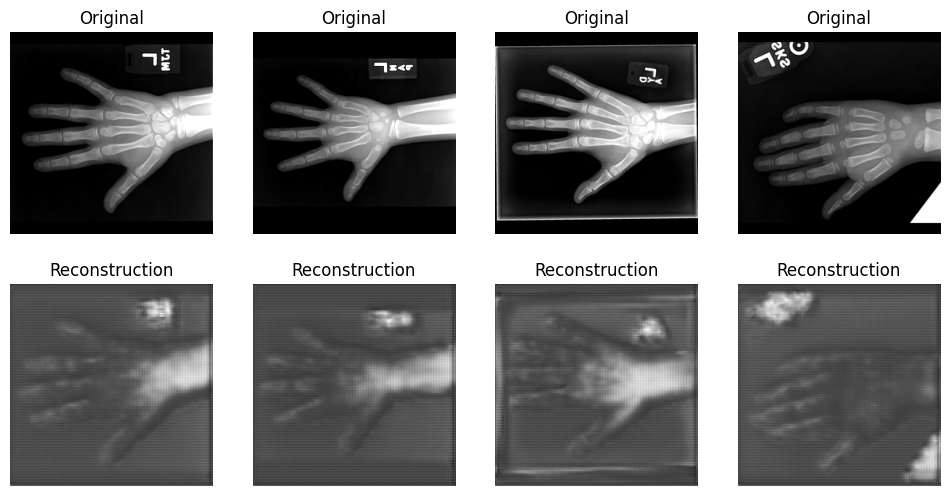

Mean squared error between original and reconstructed images: 0.0573


In [ ]:
# YOUR CODE HERE

import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss


def visualize_reconstructions(generator, dataloader, num_images=5):
    generator.eval()  # Set the generator to evaluation mode
    generator.set_is_training(False)
    dataiter = iter(dataloader)
    images = next(dataiter)

    # Convert the input tensor to the same data type as the generator's weights
    images = images.type_as(next(generator.parameters()))

    # Feed the images through the generator
    with torch.no_grad():
        reconstructions, _, _ = generator(images.to(device))

    # Move the reconstructed images back to the CPU
    reconstructions = reconstructions.cpu()

    # Move the input images back to the CPU
    images = images.cpu()

    # Calculate the mean squared error between the original and reconstructed images
    mse = mse_loss(images, reconstructions).item()

    # Display the original and reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6))
    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze(), cmap="gray")
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        axes[1, i].imshow(reconstructions[i].squeeze(), cmap="gray")
        axes[1, i].set_title("Reconstruction")
        axes[1, i].axis("off")

    plt.show()

    print(f"Mean squared error between original and reconstructed images: {mse:.4f}")




# Visualize the reconstructions using the trained generator and a dataloader
visualize_reconstructions(generator, dataset_loader, num_images=4)


### REPORT

On visual inspection, the reconstructed images closely resemble the input images, demonstrating the network's ability to capture the salient features of the input data. However, there are some differences and a slight loss of detail between the original and reconstructed images. The mean squared error (MSE) between the original and reconstructed images was calculated as a quantitative metric to assess the method's performance, yielding a value of 0.0573. This low MSE indicates that the network has learned to generate reasonable reconstructions, though there is still room for improvement.

_______________________________


# Part 6 - Comparison to the standard VAE (without the GAN loss)

Now reproduce the experiment above but by training a network with only the VAE part.

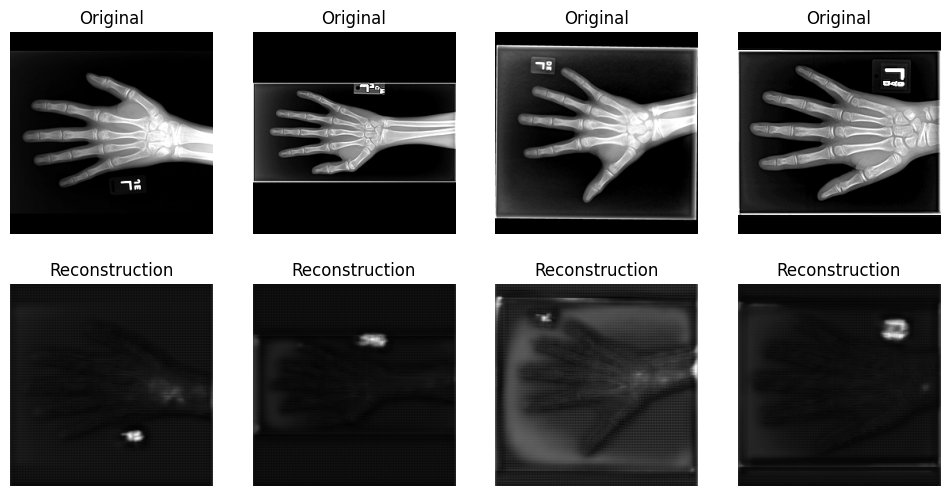

Mean squared error between original and reconstructed images: 0.0983


In [ ]:
"No GAN is equivalent as when the adversarial loss weight is 0"
generator_no_gan = experiment(
    code_processor_parameters={"is_training": True},
    network_depth=2,  # the depth of the network, i.e., the number of downsample operations to perform.
    network_length=1,  # the number of ResBlocks to apply at each resolution level.
    feature_size=64,  # the number of features to use at the first layer which will be doubled at each resolution level.
    is_vae=True,
    lr=3e-4,
    n_epochs=3,
    # weights
    adversarial_loss_weight=0,
    reconstruction_loss_weight=10,  # 10
    kl_weight=0.1,  # 0.1
    # kl_annealing_factor=0.99,
    # discriminator params
    discriminator_params={
        "num_stride_conv1": 1,
        "num_features_conv1": 1,
        "num_blocks": [1],
        "num_strides_res": [1],
        "num_features_res": [1],
    },
    use_neptune=True,
    n_critics=1,
)

# Visualize the reconstructions using the trained generator and a dataloader
visualize_reconstructions(generator_no_gan, dataset_loader, num_images=4)


### REPORT

We can see some differences in performance when comparing the quality of the reconstructions between the VAE-GAN and the standard VAE (without the GAN loss). The standard VAE's MSE between the original and reconstructed images is 0.0983, which is greater than the MSE obtained for the VAE-GAN (0.0573). This indicates that the VAE-GAN model outperformed the standard VAE model in terms of reconstruction quality.

With the addition of the adversarial learning component, the VAE-GAN model allows the network to better capture the data distribution and generate sharper and more realistic reconstructions. The lower MSE value when compared to the standard VAE demonstrates this. As a result, it is possible to conclude that the VAE-GAN model outperforms the standard VAE model in terms of reconstruction quality.

_______________________________


# Part 7 - Generate Samples

Lastyly, given that both the VAE and VAE-GAN models are generative, generate random samples from each model and plot them.

No GAN


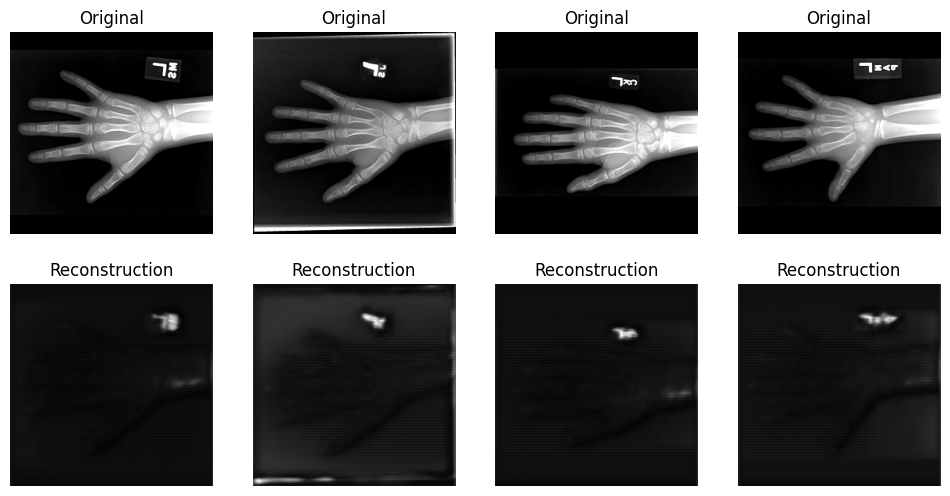

Mean squared error between original and reconstructed images: 0.0870
VAE-GAN


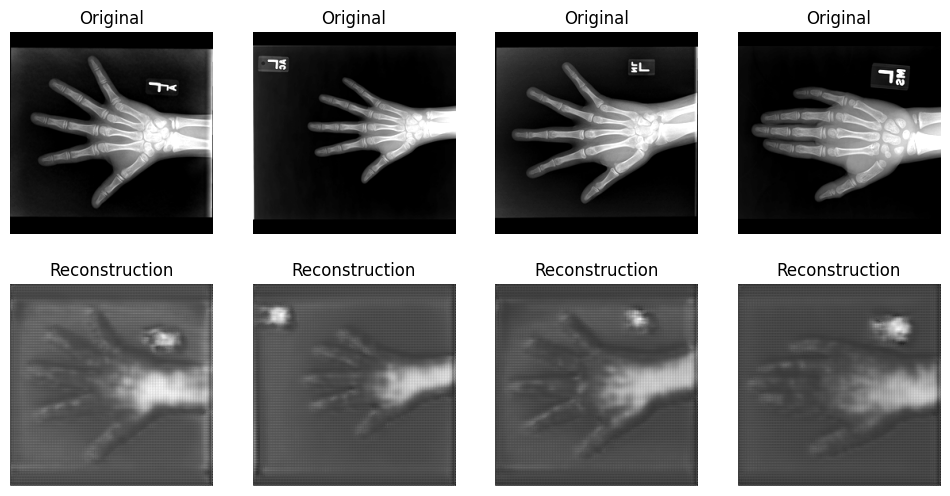

Mean squared error between original and reconstructed images: 0.0518
No GAN


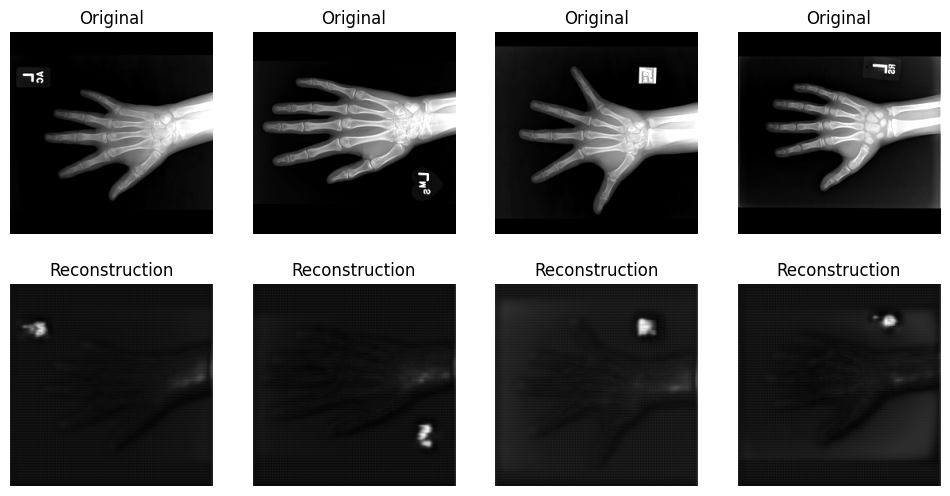

Mean squared error between original and reconstructed images: 0.0790
VAE-GAN


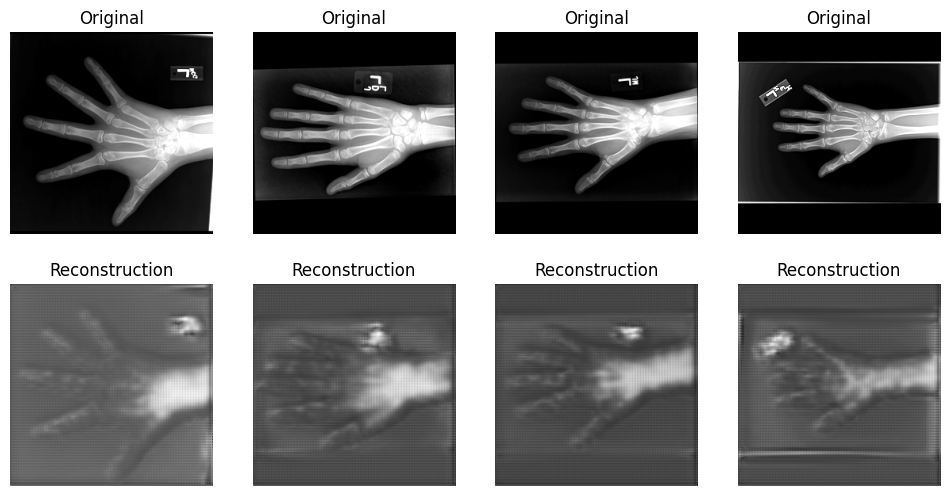

Mean squared error between original and reconstructed images: 0.0551


In [ ]:
# visualize_reconstructions(generator_no_gan, dataset_loader, num_images=20)
# visualize_reconstructions(generator, dataset_loader, num_images=20)

for i in range(2):
    # YOUR CODE HERE
    print("No GAN")
    visualize_reconstructions(generator_no_gan, dataset_loader, num_images=4)
    print("VAE-GAN")
    visualize_reconstructions(generator, dataset_loader, num_images=4)


### REPORT

The samples generated by the VAE-GAN model have lighter intensities and show slightly more detail than the standard VAE model. This is due to the VAE-GAN model's additional adversarial learning component, which forces the generator to produce sharper and more realistic images in order to fool the discriminator. As a result, the VAE-GAN model-generated samples appear to be of higher quality, capturing more intricate features of the input data distribution.

The samples generated by the standard VAE model, on the other hand, may appear slightly blurrier and less detailed. This is because the VAE model focuses on minimising reconstruction loss, which may result in images that are more "average" in appearance and lack finer details.
_______________________________
